In [106]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

In [107]:
data = np.genfromtxt("XRD_scan_data/Al2O3_Mesh 80 (180 to 212 microns)_1.xy", skip_header=1)

angle = data[:,0]
I = data[:,1]

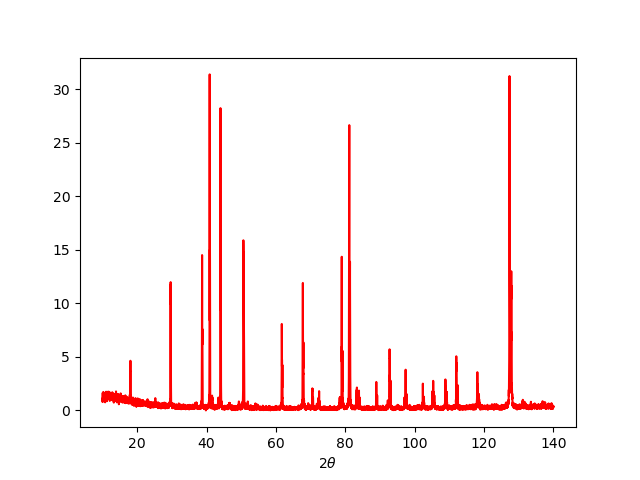

In [108]:
fig,ax = plt.subplots()
ax.plot(angle,I,'r-')
ax.set_xlabel(r'2$\theta$')
plt.show()

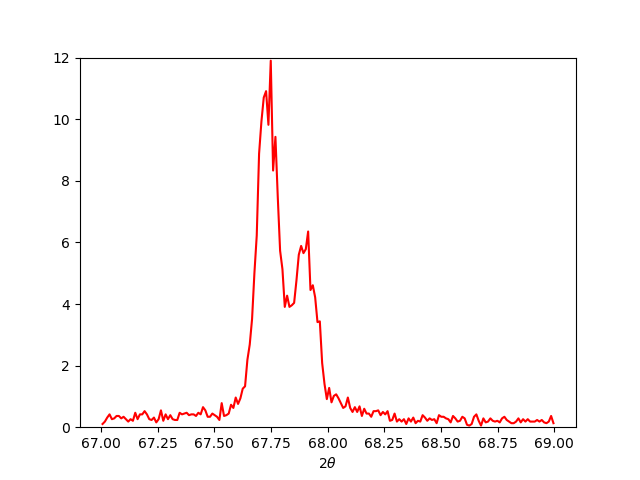

In [109]:
peak_mask = np.logical_and(angle>67, angle<69)
ang_P = angle[peak_mask]
I_P= I[peak_mask]

fig,ax = plt.subplots()
ax.plot(ang_P,I_P,'r-')
ax.set_xlabel(r'2$\theta$')
ax.set_ylim((0,12))
plt.show()

In [122]:
# for each mesh8000
class mesh:
    def __init__(self, angle, intensity, pmin, pmax):
        self.ang = angle
        self.I = intensity
        self.pmin = pmin
        self.pmax = pmax

data = np.genfromtxt("XRD_scan_data/Al2O3_Mesh 80 (180 to 212 microns)_1.xy", skip_header=1)
twoTheta = data[:,0]
I_sum = data[:,1]*0 # initialise as empty because we will sum into it

# MESH 80 (180 to 212 microns)
mesh_80 = mesh(twoTheta,I_sum,180, 212)
for i in range(1,5):
    fname = f"XRD_scan_data/Al2O3_Mesh 80 (180 to 212 microns)_{i}.xy"
    temp = np.genfromtxt(fname, skip_header=1)
    intensity = temp[:,1]
    mesh_80.I = mesh_80.I + intensity
    
# MESH 150 (75 to 106 microns)
mesh_150 = mesh(twoTheta,I_sum,75, 106)
for i in range(1,5):
    # Removing 1 because it is anomolous
    if i == 1:
        continue

    fname = f"XRD_scan_data/Al2O3_Mesh 150 (75 to 106 microns)_{i}.xy"
    temp = np.genfromtxt(fname, skip_header=1)
    intensity = temp[:,1]
    mesh_150.I = mesh_150.I + intensity

# MESH 180 (63 to 90 microns)
mesh_180 = mesh(twoTheta,I_sum,63, 90)
for i in range(1,5):
    fname = f"XRD_scan_data/Al2O3_Mesh 180 (63 to 90 microns)_{i}.xy"
    temp = np.genfromtxt(fname, skip_header=1)
    intensity = temp[:,1]
    mesh_180.I = mesh_180.I + intensity


# MESH 240 (53 to 75 microns)
mesh_240 = mesh(twoTheta,I_sum,53, 75)
for i in range(1,5):
    fname = f"XRD_scan_data/Al2O3_Mesh 240 (53 to 75 microns)_{i}.xy"
    temp = np.genfromtxt(fname, skip_header=1)
    intensity = temp[:,1]
    mesh_240.I = mesh_240.I + intensity


# MESH 320 (40 to 50 microns)
mesh_320 = mesh(twoTheta,I_sum,40, 50)
for i in range(1,5):
    fname = f"XRD_scan_data/Al2O3_Mesh 320 (40 to 50 microns)_{i}.xy"
    temp = np.genfromtxt(fname, skip_header=1)
    intensity = temp[:,1]
    mesh_320.I = mesh_320.I + intensity


# MESH 500 (14 to 20 microns)
mesh_500 = mesh(twoTheta,I_sum,14, 20)
for i in range(1,5):
    fname = f"XRD_scan_data/Al2O3_Mesh 500 (14 to 20 microns)_{i}.xy"
    temp = np.genfromtxt(fname, skip_header=1)
    intensity = temp[:,1]
    mesh_500.I = mesh_500.I + intensity


# MESH 600 (10 to 14 microns)
mesh_600 = mesh(twoTheta,I_sum,10, 14)
for i in range(1,5):
    fname = f"XRD_scan_data/Al2O3_Mesh 600 (10 to 14 microns)_{i}.xy"
    temp = np.genfromtxt(fname, skip_header=1)
    intensity = temp[:,1]
    mesh_600.I = mesh_600.I + intensity


# MESH 1200 (3.5 to 5 microns)
mesh_1200 = mesh(twoTheta,I_sum,10, 5)
for i in range(1,5):
    fname = f"XRD_scan_data/Al2O3_Mesh 1200 (3.5 to 5 microns)_{i}.xy"
    temp = np.genfromtxt(fname, skip_header=1)
    intensity = temp[:,1]
    mesh_1200.I = mesh_1200.I + intensity




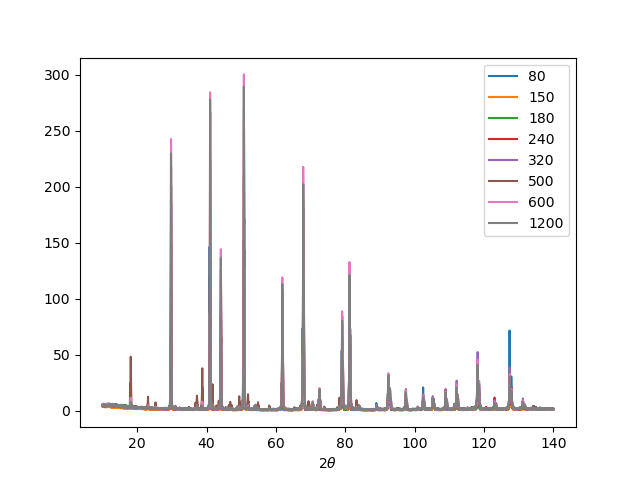

In [123]:

''' Plotting after summing '''
fig,ax = plt.subplots()
ax.plot(mesh_80.ang, mesh_80.I, label='80')
ax.plot(mesh_150.ang, mesh_150.I, label='150')
ax.plot(mesh_180.ang, mesh_180.I, label='180')
ax.plot(mesh_240.ang, mesh_240.I, label='240')
ax.plot(mesh_320.ang, mesh_320.I, label='320')
ax.plot(mesh_500.ang, mesh_500.I, label='500')
ax.plot(mesh_600.ang, mesh_600.I, label='600')
ax.plot(mesh_1200.ang, mesh_1200.I, label='1200')
ax.set_xlabel(r"$2\theta$")
ax.legend()
plt.show()

In [124]:
''' Cleaning '''

from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_asls(y, lam=1e5, p=0.01, niter=10):
    """
    Asymmetric least squares baseline (Eilers & Boelens).
    y     : 1D array of intensities
    lam   : smoothness (higher = smoother baseline)
    p     : asymmetry (0<p<1). Smaller p hugs below peaks more strongly.
    niter : reweight iterations
    """
    y = np.asarray(y, float)
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * (D @ D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y <= z)
    return z

def subtract_background_asls(x, y, lam=1e5, p=0.01, niter=10, clip_to_zero=True):
    bkg = baseline_asls(y, lam=lam, p=p, niter=niter)
    y_corr = y - bkg
    if clip_to_zero:
        y_corr = np.maximum(y_corr, 0)
    return bkg, y_corr

mesh_80.bkg, mesh_80.I_clean = subtract_background_asls(mesh_80.ang, mesh_80.I, lam=1e7, p=0.005)
mesh_150.bkg, mesh_150.I_clean = subtract_background_asls(mesh_150.ang, mesh_150.I, lam=1e7, p=0.005)
mesh_180.bkg, mesh_180.I_clean = subtract_background_asls(mesh_180.ang, mesh_180.I, lam=1e7, p=0.005)
mesh_240.bkg, mesh_240.I_clean = subtract_background_asls(mesh_240.ang, mesh_240.I, lam=1e7, p=0.005)
mesh_320.bkg, mesh_320.I_clean = subtract_background_asls(mesh_320.ang, mesh_320.I, lam=1e7, p=0.005)
mesh_500.bkg, mesh_500.I_clean = subtract_background_asls(mesh_500.ang, mesh_500.I, lam=1e7, p=0.005)
mesh_600.bkg, mesh_600.I_clean = subtract_background_asls(mesh_600.ang, mesh_600.I, lam=1e7, p=0.005)
mesh_1200.bkg, mesh_1200.I_clean = subtract_background_asls(mesh_1200.ang, mesh_1200.I, lam=1e7, p=0.005)



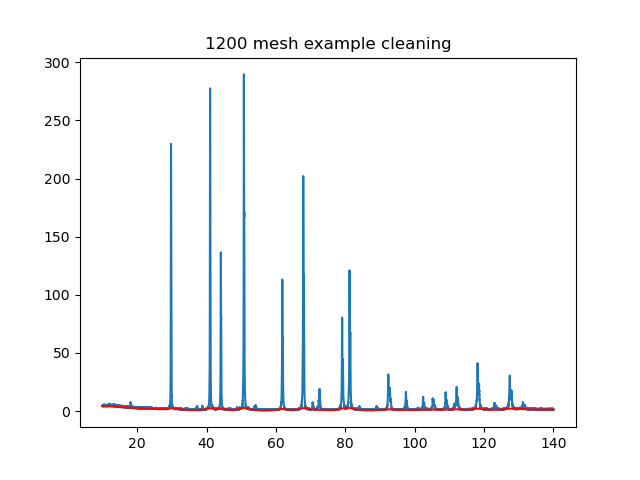

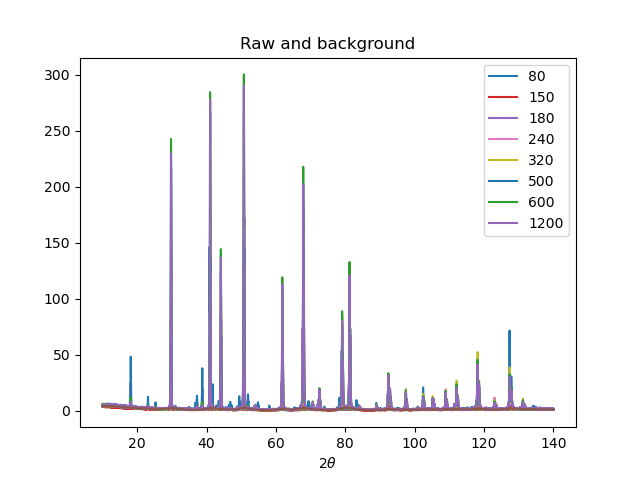

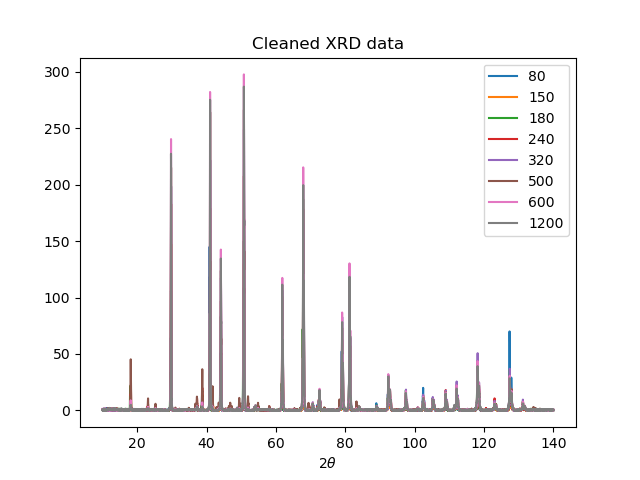

In [125]:
''' Plotting cleaned results'''

fig,ax = plt.subplots()
ax.plot(mesh_1200.ang, mesh_1200.I)
ax.plot(mesh_1200.ang, mesh_1200.bkg, 'r')
ax.set_title('1200 mesh example cleaning')
plt.show()

fig,ax = plt.subplots()
ax.plot(mesh_80.ang, mesh_80.I, label='80')
ax.plot(mesh_80.ang, mesh_80.bkg)
ax.plot(mesh_150.ang, mesh_150.bkg)
ax.plot(mesh_150.ang, mesh_150.I, label='150')
ax.plot(mesh_180.ang, mesh_180.I, label='180')
ax.plot(mesh_180.ang, mesh_180.bkg)
ax.plot(mesh_240.ang, mesh_240.I, label='240')
ax.plot(mesh_240.ang, mesh_240.bkg)
ax.plot(mesh_320.ang, mesh_320.I, label='320')
ax.plot(mesh_320.ang, mesh_320.bkg)
ax.plot(mesh_500.ang, mesh_500.I, label='500')
ax.plot(mesh_500.ang, mesh_500.bkg)
ax.plot(mesh_600.ang, mesh_600.I, label='600')
ax.plot(mesh_600.ang, mesh_600.bkg)
ax.plot(mesh_1200.ang, mesh_1200.I, label='1200')
ax.plot(mesh_1200.ang, mesh_1200.bkg)
ax.set_xlabel(r"$2\theta$")
ax.legend()
ax.set_title('Raw and background')
plt.show()

fig,ax = plt.subplots()
ax.plot(mesh_80.ang, mesh_80.I_clean, label='80')
ax.plot(mesh_150.ang, mesh_150.I_clean, label='150')
ax.plot(mesh_180.ang, mesh_180.I_clean, label='180')
ax.plot(mesh_240.ang, mesh_240.I_clean, label='240')
ax.plot(mesh_320.ang, mesh_320.I_clean, label='320')
ax.plot(mesh_500.ang, mesh_500.I_clean, label='500')
ax.plot(mesh_600.ang, mesh_600.I_clean, label='600')
ax.plot(mesh_1200.ang, mesh_1200.I_clean, label='1200')
ax.set_xlabel(r"$2\theta$")
ax.legend()
ax.set_title('Cleaned XRD data')
plt.show()

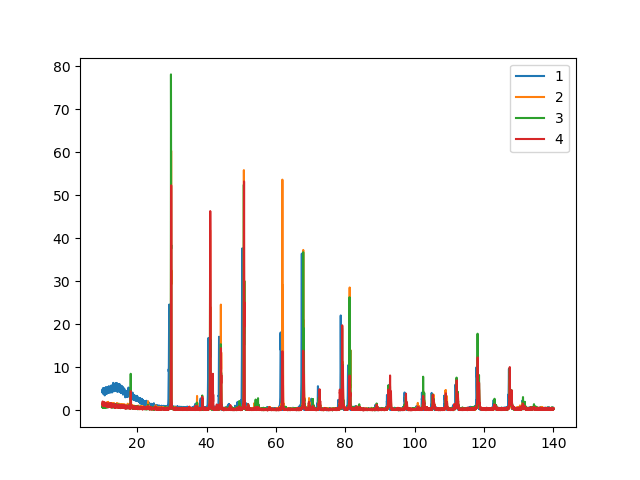

Remove the 150_1 dataset because it has significant peak shift, missing peaks, and much greater noise.


In [126]:
''' Checking the 150 mesh data set'''
mesh_150_1 = np.genfromtxt('XRD_scan_data/Al2O3_Mesh 150 (75 to 106 microns)_1.xy', skip_header=1)
mesh_150_2 = np.genfromtxt('XRD_scan_data/Al2O3_Mesh 150 (75 to 106 microns)_2.xy', skip_header=1)
mesh_150_3 = np.genfromtxt('XRD_scan_data/Al2O3_Mesh 150 (75 to 106 microns)_3.xy', skip_header=1)
mesh_150_4 = np.genfromtxt('XRD_scan_data/Al2O3_Mesh 150 (75 to 106 microns)_4.xy', skip_header=1)

plt.figure()
plt.plot(mesh_150_1[:,0], mesh_150_1[:,1], label='1')
plt.plot(mesh_150_2[:,0], mesh_150_2[:,1], label='2')
plt.plot(mesh_150_3[:,0], mesh_150_3[:,1], label='3')
plt.plot(mesh_150_4[:,0], mesh_150_4[:,1], label='4')
plt.legend()
plt.show()

print("Remove the 150_1 dataset because it has significant peak shift, missing peaks, and much greater noise.")

In [175]:
''' Correcting for scale using the (2,1,10 peak) '''

# For each mesh set, measure the Ig for (2 1 10). Calculate a scaling factor k that scales it to the known |Fg|^2. Integrate 126 - 129
# Apply this scaling factor to all intensities for that mesh. Now, the scaled intensities will obey Ig = E|Fg|^2.
# Save the corrected intensities for peaks of interest: (1 1 0), (2 2 0), (3 0 0)
# Integration angle windows:
# (1 1  0):  43.7 - 45
# (2 2  0):  96.5 - 98.5
# (3 0  0):  80.5 - 82.0
# (2 1 10): 126.0 - 129.0

Fg_2110 = -135.82666940
FgSq_2110 = Fg_2110**2

mesh_list = [mesh_80, mesh_150, mesh_180, mesh_240, mesh_320, mesh_500, mesh_600, mesh_1200]

for mesh in mesh_list:

    # define integration masks
    mask_110 = np.logical_and(mesh.ang > 43.7, mesh.ang < 45.0)
    mask_220 = np.logical_and(mesh.ang > 96.5, mesh.ang < 98.5)
    mask_300 = np.logical_and(mesh.ang > 80.5, mesh.ang < 82.0)
    mask_2110 = np.logical_and(mesh.ang > 126.0, mesh.ang < 129.0)

    # calculate scale factor k, and apply it
    I_2110 = np.sum(mesh.I_clean[mask_2110])
    angles_2110 = mesh.ang[mask_2110]

    mesh.scale_factor = FgSq_2110/np.sum(mesh.I_clean[mask_2110])
    mesh.I_scaled = mesh.I_clean * mesh.scale_factor

    # Get all intensities of interest
    mesh.I_110 = np.sum(mesh.I_scaled[mask_110])
    mesh.I_220 = np.sum(mesh.I_scaled[mask_220])
    mesh.I_300 = np.sum(mesh.I_scaled[mask_300])
    mesh.I_2110 = np.sum(mesh.I_scaled[mask_2110])

    # Convert to Fg
    mesh.F_110 = np.sqrt(mesh.I_110)
    mesh.F_220 = np.sqrt(mesh.I_220)
    mesh.F_300 = np.sqrt(mesh.I_300)
    mesh.F_2110 = np.sqrt(mesh.I_2110)

    print(f"{mesh.pmin:3d} - {mesh.pmax:3d}:  F_110 = {mesh.F_110:>8.2f}, F_220 = {mesh.F_220:>6.2f}, F_300 = {mesh.F_300:>6.2f}, F_2110 = {mesh.F_2110:>6.2f}")
    

180 - 212:  F_110 =    94.67, F_220 =  49.60, F_300 =  92.61, F_2110 = 135.83
 75 - 106:  F_110 =   130.08, F_220 =  76.45, F_300 = 158.63, F_2110 = 135.83
 63 -  90:  F_110 =   159.35, F_220 =  81.92, F_300 = 163.69, F_2110 = 135.83
 53 -  75:  F_110 =   175.19, F_220 =  83.65, F_300 = 187.51, F_2110 = 135.83
 40 -  50:  F_110 =   173.75, F_220 =  84.76, F_300 = 197.11, F_2110 = 135.83
 14 -  20:  F_110 =   164.94, F_220 =  78.78, F_300 = 187.09, F_2110 = 135.83
 10 -  14:  F_110 =   173.89, F_220 =  81.48, F_300 = 202.41, F_2110 = 135.83
 10 -   5:  F_110 =   173.19, F_220 =  81.71, F_300 = 201.47, F_2110 = 135.83


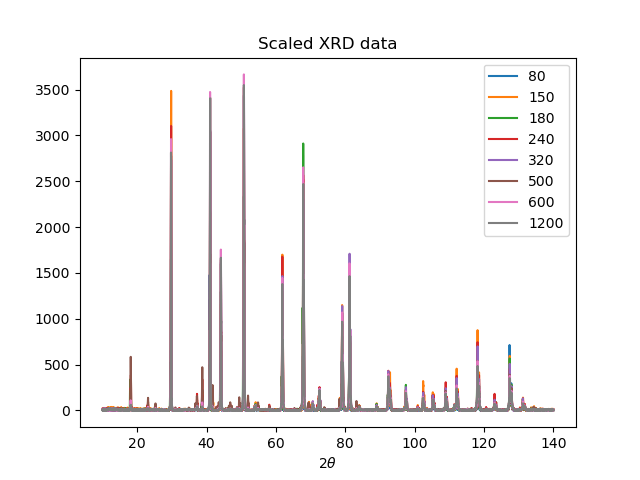

In [143]:
''' Plotting scaled data'''

fig,ax = plt.subplots()
ax.plot(mesh_80.ang, mesh_80.I_scaled, label='80')
ax.plot(mesh_150.ang, mesh_150.I_scaled, label='150')
ax.plot(mesh_180.ang, mesh_180.I_scaled, label='180')
ax.plot(mesh_240.ang, mesh_240.I_scaled, label='240')
ax.plot(mesh_320.ang, mesh_320.I_scaled, label='320')
ax.plot(mesh_500.ang, mesh_500.I_scaled, label='500')
ax.plot(mesh_600.ang, mesh_600.I_scaled, label='600')
ax.plot(mesh_1200.ang, mesh_1200.I_scaled, label='1200')
ax.set_xlabel(r"$2\theta$")
ax.legend()
ax.set_title('Scaled XRD data')
plt.show()

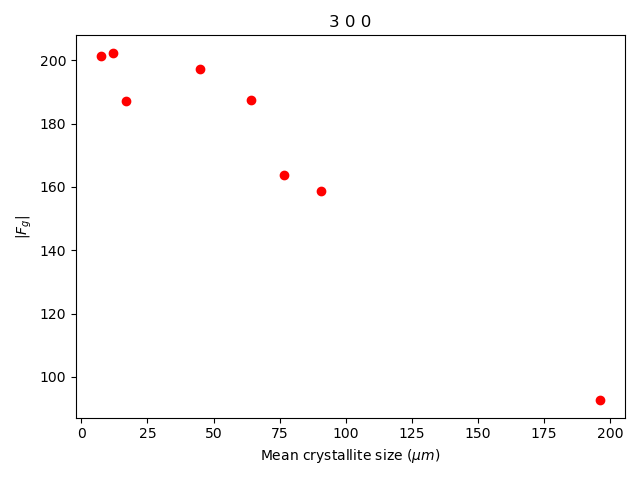

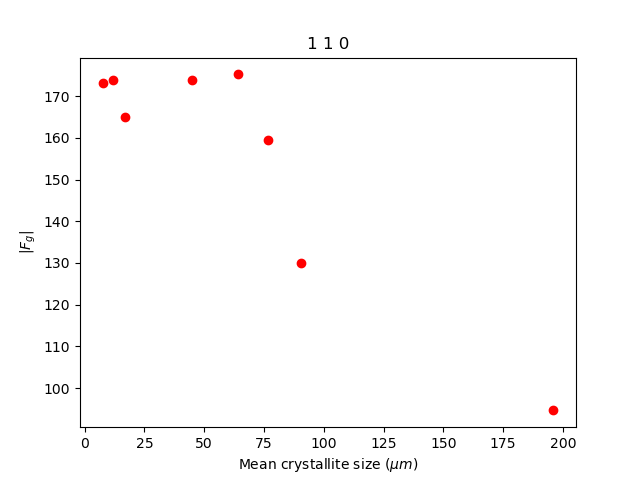

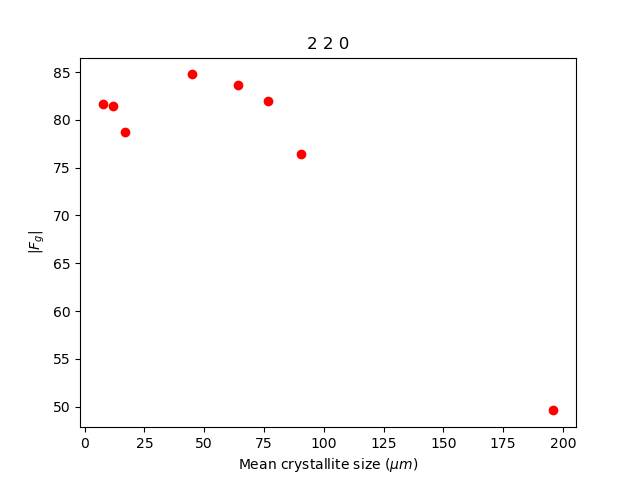

In [177]:
''' Plotting Back-calculated Structure Factors'''

# 110
fig,ax110 = plt.subplots()
fig,ax220 = plt.subplots()
fig,ax300 = plt.subplots()

for mesh in mesh_list:

    ax110.plot(np.mean([mesh.pmin,mesh.pmax]), mesh.F_110, 'ro') # 1 1 0
    ax220.plot(np.mean([mesh.pmin,mesh.pmax]), mesh.F_220, 'ro') # 2 2 0
    ax300.plot(np.mean([mesh.pmin,mesh.pmax]), mesh.F_300, 'ro') # 3 0 0

ax110.set_xlabel('Mean crystallite size ($\mu m$)')
ax110.set_ylabel('|$F_g$|')
ax110.set_title('1 1 0')

ax220.set_xlabel('Mean crystallite size ($\mu m$)')
ax220.set_ylabel('|$F_g$|')
ax220.set_title('2 2 0')

ax300.set_xlabel('Mean crystallite size ($\mu m$)')
ax300.set_ylabel('|$F_g$|')
ax300.set_title('3 0 0')

plt.tight_layout()
plt.show()

In [ ]:
''' Plotting all the peaks '''
